In [23]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
import datetime as dt
import math
import numpy as np
from osgeo import gdal
import osr
import random
%matplotlib inline

import time



# define path to classification data
path = f'data/classification_data/'


""" //////////////////////// functions //////////////////////// """

# function to read in a data cube from a geo tiff file
def geotiff_to_datacube(fname):
    
    ds = gdal.Open(fname)
    
    geotransform = ds.GetGeoTransform()
    
    proj = osr.SpatialReference(wkt=ds.GetProjection())
    epsg = int(proj.GetAttrValue('AUTHORITY',1))
    
    xy_shape = np.array(ds.GetRasterBand(1).ReadAsArray()).shape
    
    # get number of bands in raster file
    n_bands = ds.RasterCount
    
    # initialize a data cube
    xyz_shape = xy_shape + (n_bands,)
    data_cube = np.ndarray(xyz_shape)
    
    # fill it with bands
    for i in range(1,n_bands+1):
        data_cube[:,:,i-1] =  np.array(ds.GetRasterBand(i).ReadAsArray())
    
    return data_cube, geotransform, epsg
    # end of read in datacube function
    
    
def save_geotiff(data_cube,geotransform,epsg,fname):
    
    n_rows, n_cols = data_cube.shape[0:2]
    n_bands = data_cube.shape[2] if len(data_cube.shape)>2 else 1
    
    # open geo tiff file
    ds = gdal.GetDriverByName('GTiff').Create('placeholder.tif',n_cols, n_rows, n_bands, gdal.GDT_Float32)
    ds.SetGeoTransform(geotransform)
    
    # set crs
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    ds.SetProjection(srs.ExportToWkt())
    
    # write data cube to geo tiff
    if n_bands==1:
        ds.GetRasterBand(1).WriteArray(data_cube[:,:])
    else:
        for i_band in range(n_bands):
            ds.GetRasterBand(i_band+1).WriteArray(data_cube[:,:,i_band])
    
    dst_ds = gdal.GetDriverByName('GTiff').CreateCopy(fname+'.tif', ds)
    dst_ds = None
    # end of save function
    
    
    # function to plot a classified image  
def plot(image_classified):
     
    # define class labels and colors
    classes = [
        'Artificial areas',
        'Grass and herb vegetation',
        'Brush vegetation', 'Tree vegetation',
        'Bare land', 'Water',
        'Glacier, perpetual snow'
    ]
    
    hex_colors = [
        "#FF0000",
        "#FFFF00",
        "#B2B200",
        "#00B200",
        "#804D33",
        '#0000FF',
        '#B2B2B2'
    ]
    
    cmap = mpl.colors.ListedColormap(hex_colors)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,7), cmap.N)
        
    # plot map
    fig, ax = plt.subplots(figsize=(10,10))        
    im = ax.imshow(image_classified, cmap=cmap, norm=norm)

    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size="5%", pad=0.4, pack_start=False)
    fig.add_axes(cax)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical", ticks=np.linspace(0,7,8))
    cbar.ax.set_yticklabels(classes)
    plt.show()
    # end of plot function
    
      

def train_validate_classifier(clf, train, test, features, label):
        
    # getting training and testing features
    X_train = train[features]
    X_test = test[features]
    
    # getting training and testing labels
    y_train = train[label]
    y_test = test[label]
    
    # training classifier
    start_time = time.time()
    clf.fit(X_train,y_train)
    run_time = time.time() - start_time
    
    # creating error matrix for validation
    y_pred = clf.predict(X_test)
    error_matrix = confusion_matrix(y_test, y_pred)
    
    return error_matrix, run_time



def apply_gaussian_kernel(data_kernel,gaussian_kernel):
    
    assert(data_kernel.shape==gaussian_kernel.shape)
    
    class_probabilities = {}
    for index, prob in np.ndenumerate(gaussian_kernel):
        class_ = int(data_kernel[index[0],index[1]])
        class_prob = class_probabilities.get(class_,0)
        class_probabilities[class_] = class_prob + prob
    
    new_class = max(class_probabilities, key=class_probabilities.get)
    return new_class




def gaussian_filter(image,kernel_size):
    
    kernel5 = np.array([
        [1,4,7,4,1],
        [4,16,26,16,4],
        [7,26,41,26,7],
        [4,16,26,16,4],
        [1,4,7,4,1]
    ])

    kernel3 = np.array([
        [1,2,1],
        [2,4,2],
        [1,2,1]
    ])
    
    
    gaussian_kernel = kernel3 if kernel_size==3 else kernel5 
    offset = gaussian_kernel.shape[0]//2

    new_image = np.copy(image)
    
    # loop over all pixels ignoring edges
    for i in range(offset,image.shape[0]-offset):
        for j in range(offset,image.shape[1]-offset):
        
        
            data_kernel = image[i-offset:i+offset+1,j-offset:j+offset+1,0]
            new_image[i,j,0] = apply_gaussian_kernel(data_kernel,gaussian_kernel)

               
    return new_image


def validate_filtered(trained_clf,spatial,test,feature_image,label):
    
    y_test, y_pred = ([],[])
    
    for roi in rois:
        
        # subsetting test data to roi
        test_roi = test[test['roi']==roi]
        x_coords = list(test_roi['X'])
        y_coords = list(test_roi['Y'])
        labels = list(test_roi[label])
        
        # getting image data for roi
        year = 2006 if roi=='roi2' else 2007
        image, geotransform, epsg = geotiff_to_datacube(f'{feature_image}_{roi}_{year}.tif')
        xOrigin = geotransform[0]
        yOrigin = geotransform[3]
        pixelWidth = geotransform[1]
        pixelHeight = -geotransform[5]
        
        for i, (x_coord,y_coord,class_) in enumerate(zip(x_coords,y_coords,labels)):
            
            # computing column and row indices
            icol = int((x_coord - xOrigin) / pixelWidth)
            irow = int((yOrigin - y_coord ) / pixelHeight)

            if not spatial:
                
                # create vector of pixels for classifier input
                kernel = image[irow-1:irow+2,icol-1:icol+2,:]
                feature_vector = kernel.reshape((3*3, kernel.shape[2]))
            
            else:
                
                # create vector of kernels for classifier input
                feature_vector = []
                for irowk in range(irow-1,irow+2):
                    for icolk in range(icol-1,icol+2):
                        kernel = image[irowk-1:irowk+2,icolk-1:icolk+2,:]
                        kernel_flattened = kernel.flatten()
                        feature_vector.append(kernel_flattened)
                feature_vector = np.array(feature_vector)
                if i ==0: print(feature_vector.shape)
                                            
            # classify pixel vector and reshape to image
            predictions = trained_clf.predict(feature_vector)
                
            classified_kernel = predictions.reshape((3,3))
        
            class_pred = apply_gaussian_kernel(classified_kernel,gaussian_kernel3)
            
            y_test.append(class_)
            y_pred.append(class_pred)
                
    
    error_matrix = confusion_matrix(y_test, y_pred)
    
    # computing average user's and producer's accuracy
    avg_uacc = compute_avg_uacc(error_matrix)
    avg_pacc = compute_avg_pacc(error_matrix)
    
    return (avg_uacc, avg_pacc)


""" //////////////////////// classes //////////////////////// """

# class to create a deep neural network (dnn). the dnn object is compatible with scikit-learn's
# classifier, i.e. also provides the fit and predict methods.
class DeepNeuralNetwork():
    
    def __init__(self):
        self.trained = False
        self.enc = OneHotEncoder(categories='auto')
        self.model = False
        
        # end of init method
    
    def fit(self, X_train, y_train):
        
        # one hot encoding data
        y_train_onehot = np.asarray(y_train)
        self.enc.fit(y_train_onehot.reshape(-1,1))
        y_train_onehot = self.enc.transform(y_train_onehot.reshape(-1,1)).todense()
        
        # getting input and output dimension of data
        input_dim = len(X_train.columns)
        output_dim = y_train_onehot.shape[1]
        
        # setting up model
        self.model = keras.Sequential([
            keras.layers.Dense(200, input_dim=input_dim, activation=tf.nn.tanh),
            keras.layers.Dense(100, activation=tf.nn.tanh),
            keras.layers.Dense(50, activation=tf.nn.tanh),
            keras.layers.Dense(output_dim, activation=tf.nn.softmax)
        ])
        opt = keras.optimizers.Adam(lr=0.001)
        self.model.compile(
          optimizer=opt,
          loss='categorical_crossentropy',
          metrics = ["accuracy"]
        )
        
        # training deep neural network
        batchsize = 48
        for i in range(6):
            self.model.fit(X_train, y_train_onehot, epochs=20, batch_size=batchsize, verbose=0)#, sample_weight=sample_weights.reshape(-1))
            batchsize *= 2
        
        self.trained = True
        # end of fit method
        

    def predict(self, X_test):
        
        if self.trained:
            y_pred = np.argmax(self.model.predict(X_test), axis=1)
        
        return y_pred
        # end of predict method

        

# class that provides methods to assess classification results by implementing various accuracy metrics.
class ErrorMatrix:

    
    def __init__(self,matrix,labels=False):
        
        self.matrix = matrix
        self.n_classes = matrix.shape[0]

        self.labels = labels if labels else list(range(self.n_classes))
        
        
    def column_total(self):
        
        return list(np.sum(self.matrix, axis=0))
        
    
    def row_total(self):
        
        return list(np.sum(self.matrix, axis=1))
    
    
    def total(self):
        
        return sum(self.column_total())
        
    
    def users_accuracies(self):
    
        row_total = self.row_total()
        uas = [self.matrix[i,i]/float(row_total[i])*100 for i in range(self.n_classes)]
    
        return uas

    
    def average_users_accuracy(self):
        
        return np.mean(self.users_accuracies())
    
    
    def producers_accuracies(self):
    
        column_total = self.column_total()
        pas = [self.matrix[i,i]/float(column_total[i])*100 for i in range(self.n_classes)]
    
        return pas
    
    
    def average_producers_accuracy(self):
        
        return np.mean(self.producers_accuracies())
    
    
    def overall_accuracy(self):
        
        correctly_classified = sum([self.matrix[i,i] for i in range(self.n_classes)])
        total = sum(list(np.sum(self.matrix, axis=1)))
        oa = correctly_classified/float(total)*100
        
        return oa
    
    
    def average_accuracy(self):
    
        aa = np.mean(self.users_accuracies())
    
        return aa

    
    def mean_accuracy(self):
    
        ma = (self.average_accuracy()+self.overall_accuracy())/2.
    
        return ma
    
    
    def kappa(self):
        
        # Cohen's kappa (Cohen, 1960; doi:10.1177/001316446002000104)
        X_test, y_pred = ([],[])
        for index, value in np.ndenumerate(self.matrix):
            pred, label = index
            X_test.extend([label for _ in range(value)])
            y_pred.extend([pred for _ in range(value)])
        
        return cohen_kappa_score(X_test,y_pred)
    
    
    def accuracy_metrics(self):
        
        metrics = {
            'OA': self.overall_accuracy(),
            'AvgUA': self.average_users_accuracy(),
            'AvgPA': self.average_producers_accuracy(),
            'AA': self.average_accuracy(),
            'MA': self.mean_accuracy(),
            'Kappa': self.kappa()
        }

        return metrics
        
        
    def print_matrix(self):
        
        print(self.matrix)
    
    
    def print_summary(self):
        
        print(f'Summary statistics (n Samples: {self.total()})')
        
        print()
        
        # overall statistics        
        print(f'{self.overall_accuracy():.2f} % (OA)')
        print(f'{self.average_users_accuracy():.2f} % (Average UA)')
        print(f'{self.average_producers_accuracy():.2f} % (Average PA)')
        print(f'{self.average_accuracy():.2f} % (AA = Average UA)')
        print(f'{self.mean_accuracy():.2f} % (MA = (OA + AA)/2)')        
        print(f'{self.kappa():.2f} (Kappa)')
        
        print()
        
        # class wise statistics
        column_total = self.column_total()
        row_total = self.row_total()
        
        uas = self.users_accuracies()
        pas = self.producers_accuracies()
        
        for i, label in enumerate(self.labels):
            print(f'{label}: {uas[i]:.2f} % (UA) n Class: {row_total[i]}; {pas[i]:.2f} % (PA) n Ref: {column_total[i]})')
            

    
    def to_latex(self):
        
        return ''

        

In [3]:
data_coefs = pd.read_csv(f'{path}coefficients_labeled.csv')
data_coefs.head()

,roi,X,Y,land_cover,topleft_blue_c,topleft_blue_a1,topleft_blue_b1,topleft_green_c,topleft_green_a1,topleft_green_b1,...,lowerright_red_b1,lowerright_nir_c,lowerright_nir_a1,lowerright_nir_b1,lowerright_swir1_c,lowerright_swir1_a1,lowerright_swir1_b1,lowerright_swir2_c,lowerright_swir2_a1,lowerright_swir2_b1
0,roi1,667600,252600,2,380.638367,65.649033,38.340347,504.429260,-17.511360,105.570168,...,71.432404,2337.309326,-1329.805420,-254.358856,1125.302246,-367.617249,-0.383392,516.211548,-87.554733,66.352211
1,roi1,667700,252600,3,332.687958,32.793858,59.761925,421.774048,-45.964584,97.390305,...,64.486885,2031.968262,-1501.842651,-55.873653,966.418213,-525.751587,82.470558,459.251709,-175.961182,91.420761
2,roi1,667800,252600,3,306.430084,20.838465,31.285831,387.130463,-60.250031,60.218811,...,71.439423,1651.890991,-594.699707,22.281591,659.893311,-279.609406,61.193287,286.992676,-129.099976,49.272015
3,roi1,667900,252600,3,289.838318,2.063600,22.950096,367.620850,-66.887375,54.132072,...,90.105492,1693.013306,-506.476105,67.894760,635.475464,-265.514648,125.416039,281.357941,-138.290726,83.930519
4,roi1,668000,252600,3,301.951447,-8.857222,25.563393,398.568115,-87.492523,52.679016,...,67.915154,1584.583008,-763.324524,120.866425,741.023560,-299.501282,168.571472,344.163757,-136.045792,104.747475


In [4]:
data_acomp = pd.read_csv(f'{path}annual_composite_labeled.csv')
data_acomp.head()

,X,Y,land_cover,adj,roi,blue,green,red,nir,swir1,swir2
0,667600,252600,2,1,roi1,212.0,304.0,208.0,979.0,751.0,361.0
1,667700,252600,3,7,roi1,208.0,325.0,213.0,1392.0,850.0,465.0
2,667800,252600,3,8,roi1,205.0,215.0,196.0,970.0,312.0,153.0
3,667900,252600,3,7,roi1,203.0,321.0,193.0,1329.0,445.0,216.0
4,668000,252600,3,7,roi1,212.0,309.0,218.0,1224.0,588.0,312.0


In [ ]:
data_scomp = pd.read_csv(f'{path}seasonal_composite_labeled.csv')
data_scomp.head()

In [ ]:
rois = ['roi1','roi2','roi3']

label = 'land_cover'

# define features
bands = ['blue','green','red','nir','swir1','swir2']
seasons = ['spring','summer','autumn']
coefficients = ['c','a1','b1']
positions = ['topleft','topcenter','topright','midleft','midcenter','midright','lowerleft','lowercenter','lowerright']

features_ac = bands
features_sc = [f'{band}_{season}' for band in bands for season in seasons]
features_t = [f'midcenter_{band}_{coef}' for band in bands for coef in coefficients]
features_ts = [f'{pos}_{band}_{coef}' for pos in positions for band in bands for coef in coefficients]

# split between training and testing data
test_size = 0.3

# define filter used for gaussian filtering
gaussian_kernel3 = np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
])

# define classifiers
classifiers = {}
classifiers['rf'] = RandomForestClassifier(n_estimators=100,class_weight='balanced')
classifiers['svm'] = svm.SVC(gamma='scale', decision_function_shape='ovo', class_weight='balanced')
classifiers['dnn'] = DeepNeuralNetwork()



# data container and function to add data to it
data = []
def



# define number of iterations
n_iterations = 1

for i in range(n_iterations):
    print(f'Iteration: {i+1}/{n_iterations}')
    
    # splitting data (using a different split for each iteration)
    train_acomp, test_acomp = train_test_split(data_acomp, test_size=test_size)
    train_coefs, test_coefs = train_test_split(data_coefs, test_size=test_size)
        
    for clf_key in classifiers.keys():
        print(clf_key,end=' ')
        
        clf  = classifiers[clf_key]
        
        # ac (annual composite)
        error_matrix_ac, run_time_ac = train_validate_classifier(clf,train_acomp,test_acomp,features_ac,label)
        users_ac = ErrorMatrix(error_matrix_ac).users_accuracies()
        producers_ac = ErrorMatrix(error_matrix_ac).producers_accuracies()
        
        data.append((clf_key,'ac',test_size,run_time_ac,metrics_ac))
        
        ErrorMatrix(error_matrix_ac).print_matrix()
        ErrorMatrix(error_matrix_ac).print_summary()
        
        # sc (sesonal composite)
        # error_matrix_sc, run_time_sc = train_validate_classifier(clf,train_scomp,test_scomp,features_sc,label)
        # data.append((clf_key,'sc',test_size,ErrorMatrix(error_matrix_sc).accuracy_metrics(),run_time_sc)
                    
        # t (time series)
        # error_matrix_t, run_time_t = train_validate_classifier(clf,train_coefs,test_coefs,features_t,label)
        # data.append((clf_key,'t',test_size,ErrorMatrix(error_matrix_t).accuracy_metrics(),run_time_t)
                        
        # ts (time series-spatial)
        # error_matrix_ts, run_time_ts = train_validate_classifier(clf,train_coefs,test_coefs,features_ts,label)
        # data.append((clf_key,'ts',test_size,ErrorMatrix(error_matrix_ts).accuracy_metrics(),run_time_ts)
    
    print('')
    
d = {
    'classifier': [entry[0] for entry in data],
    'method': [entry[1] for entry in data],
    'testsize': [f'{(entry[2]*100):.0f}' for entry in data],
    'runtime': [entry[3] for entry in data],
    'OA': [entry[4]['OA'] for entry in data],
    'AvgUA': [entry[4]['AvgUA'] for entry in data],
    'AvgPa': [entry[4]['AvgPA'] for entry in data],
    'AA': [entry[4]['AA'] for entry in data],
    'MA': [entry[4]['MA'] for entry in data],
    'Kappa': [entry[4]['Kappa'] for entry in data],
}
df = pd.DataFrame(data=d)
df.to_csv(f'{path}classifier_comparison_data.csv', encoding='utf-8', index=False)
df.head()

Iteration: 1/1
rf [[3099  539   14  168  125   14    0]
 [ 306 7210  155 1141  520    6    0]
 [  48  883  322  652  130    3    0]
 [ 183  945   69 7047   80   17    0]
 [ 108  727   49  279 4100   11   66]
 [  32   62    2   47   60 1149    1]
 [   0    0    0    0  180    4  497]]
Summary statistics (n Samples: 31050)

75.44 % (OA)
70.07 % (Average UA)
77.47 % (Average PA)
70.07 % (AA = Average UA)
72.75 % (MA = (OA + AA)/2)
0.68 (Kappa)

0: 78.28 % (UA) n Class: 3959; 82.07 % (PA) n Ref: 3776)
1: 77.21 % (UA) n Class: 9338; 69.55 % (PA) n Ref: 10366)
2: 15.80 % (UA) n Class: 2038; 52.70 % (PA) n Ref: 611)
3: 84.49 % (UA) n Class: 8341; 75.50 % (PA) n Ref: 9334)
4: 76.78 % (UA) n Class: 5340; 78.92 % (PA) n Ref: 5195)
5: 84.92 % (UA) n Class: 1353; 95.43 % (PA) n Ref: 1204)
6: 72.98 % (UA) n Class: 681; 88.12 % (PA) n Ref: 564)
svm 

In [14]:
rois = ['roi1','roi2','roi3']


label = 'land_cover'

# define features
bands = ['blue','green','red','nir','swir1','swir2']
seasons = ['spring','summer','autumn']
coefficients = ['c','a1','b1']
positions = ['topleft','topcenter','topright','midleft','midcenter','midright','lowerleft','lowercenter','lowerright']

features_ac = bands
features_sc = [f'{band}_{season}' for band in bands for season in seasons]
features_t = [f'midcenter_{band}_{coef}' for band in bands for coef in coefficients]
features_ts = [f'{pos}_{band}_{coef}' for pos in positions for band in bands for coef in coefficients]

# define filter used for gaussian filtering
gaussian_kernel3 = np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
])

test_sizes = np.arange(0.1,0.8,0.1)

# define classifiers
classifiers = {}
classifiers['rf'] = RandomForestClassifier(n_estimators=100,class_weight='balanced')
classifiers['svm'] = svm.SVC(gamma='scale', decision_function_shape='ovo', class_weight='balanced')
classifiers['dnn'] = DeepNeuralNetwork()


# data container
data = []

# define number of iterations
n_iterations = 5

for i in range(n_iterations):
    print(f'Iteration: {i+1}/{n_iterations}')
    
    for test_size in test_sizes:
    
        # splitting data (using a different split for each iteration)
        train_comp, test_comp = train_test_split(data_comp, test_size=test_size)
        train_coefs, test_coefs = train_test_split(data_coefs, test_size=test_size)
        
        for clf_key in classifiers.keys():

            clf  = classifiers[clf_key]
        
            # ac (composite)
            error_matrix_ac, run_time_c = train_validate_classifier(clf,train_comp,test_comp,features_c,label)
            data.append((clf_key,'c',test_size,ErrorMatrix(error_matrix_c).accuracy_metrics(),run_time_c)
        
            # t (time series)
            error_matrix_t, run_time_t = train_validate_classifier(clf,train_coefs,test_coefs,features_t,label)
            data.append((clf_key,'t',test_size,ErrorMatrix(error_matrix_t).accuracy_metrics(),run_time_t)
                        
            # ts (time series-spatial)
            error_matrix_ts, run_time_ts = train_validate_classifier(clf,train_coefs,test_coefs,features_ts,label)
            data.append((clf_key,'ts',test_size,ErrorMatrix(error_matrix_ts).accuracy_metrics(),run_time_ts)
        

                        
d = {
    'classifier': [entry[0] for entry in data],
    'method': [entry[1] for entry in data],
    'testsize': [f'{(entry[2]*100):.0f}' for entry in data],
    'OA': [entry[3]['OA'] for entry in data],
    'AvgUA': [entry[3]['AvgUA'] for entry in data],
    'AvgPa': [entry[3]['AvgPA'] for entry in data],
    'AA': [entry[3]['AA'] for entry in data],
    'MA': [entry[3]['MA'] for entry in data],
    'Kappa': [entry[3]['Kappa'] for entry in data],
    'runtime': [entry[4] for entry in data]
}
                        
df = pd.DataFrame(data=d)
df.to_csv(f'{path}classification_data.csv', encoding='utf-8', index=False)
df.head()

SyntaxError: invalid syntax (<ipython-input-14-21b39ef3d535>, line 57)

KeyError: 'users'

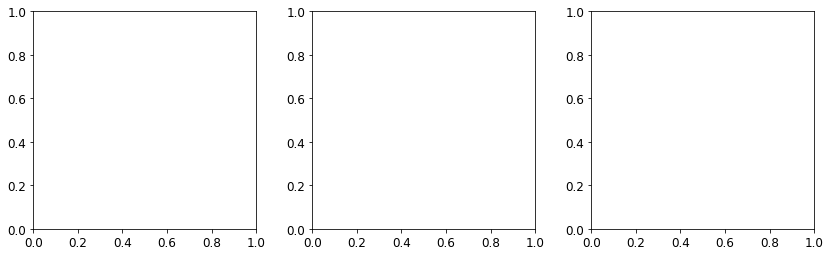

In [28]:
# plotting the classifier comparison


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



df = pd.read_csv('data/classification_data/classifier_comparison_data.csv')

grouped = df.groupby(['method','classifier'])
means = grouped.mean().to_dict()
stds = grouped.std().to_dict()




fig, axes = plt.subplots(1,3)
fig.set_figheight(4)
fig.set_figwidth(14)
plt.subplots_adjust(wspace=0.25)
axes = axes.ravel()

ax = axes[0]
fontsize = 12
plt.rcParams.update({'font.size': fontsize})


classifiers = ['rf','svm','dnn']
markers = ['o','^','*']

methods = ['c','t','ts']
inputs = ['Annual composite', 'Time series', 'Time series-spatial']
colors = ['#377eb8','#4daf4a','#984ea3']


cpoints = []
for i, clf in enumerate(classifiers):
    cpoint = ax.scatter(
        means['users'][('c',clf)],
        means['producers'][('c',clf)],
        marker=markers[i],
        color='k',
        label=clf,
        s=1,
    )
    cpoints.append(cpoint)
    


mpoints = []
for i, method in enumerate(methods):
    mpoint = ax.scatter(
        means['users'][(method,'rf')],
        means['producers'][(method,'rf')],
        marker='s',
        color=colors[i],
        label=inputs[i],
        s=1,
    )
    mpoints.append(mpoint)


for iclf, clf in enumerate(classifiers):
    for im, m in enumerate(methods):
        key = (m,clf)
        ax.errorbar(
            x=means['users'][key],
            xerr=stds['users'][key],
            y=means['producers'][key],
            yerr=stds['producers'][key],
            ms=10,
            c=colors[im],
            marker=markers[iclf],
            ecolor='k',
            elinewidth=1,
        )


lower, upper = (0.6, 0.85)
limits = [lower,upper]
ticks = np.arange(lower,upper+0.01,0.05)
labels = [f'{tick*100:.0f}' for tick in list(ticks)]
print(ticks)

ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)
ax.set_xticklabels(labels)

ax.set_xlabel('Average user\'s accuracy (%)')
ax.set_ylabel('Average producer\'s accuracy (%)')

legend_xpos = 2.68

leg1 = ax.legend(
    cpoints,
    [clf.upper() for clf in classifiers],
    title='Classifier',
    bbox_to_anchor=(legend_xpos, 0.9),
    frameon=False,
    markerscale=8,
    handletextpad=1,
)
leg1._legend_box.align = "left"

leg2 = ax.legend(
    mpoints,
    inputs,
    title='Method',
    loc='center',
    bbox_to_anchor=(legend_xpos, 0.27),
    frameon=False,
    markerscale=8,
    handletextpad=1,
)
leg2._legend_box.align = "left"
ax.add_artist(leg1)

axes[2].axis('off')
ax = axes[1]


mean_runtime_data = []
std_runtime_data = []

for m in methods:
    runtime_mean_method = [means['runtime'].get((m,clf)) for clf in classifiers]
    mean_runtime_data.append(runtime_mean_method)
    runtime_std_method = [stds['runtime'].get((m,clf)) for clf in classifiers]
    std_runtime_data.append(runtime_std_method)

for i, (mean, std) in enumerate(zip(mean_runtime_data,std_runtime_data)):
    
    # rescaling to minutes
    mean = [m/60. for m in mean]
    std = [s/60. for s in std]
    
    wbar = 0.2
    xpos = [x-wbar+i*wbar for x in range(3)]
    ax.bar(
        x=xpos,
        height=mean,
        yerr=std,
        width=0.2,
        color=colors[i],
        error_kw={'ecolor':'k','elinewidth':1},
    )

    
yticks = np.arange(0,21,5)
yticklabels = [f'{ytick:.0f}' for ytick in list(yticks)]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)



# ax.set_ylabel('Runtime (min)',rotation=270,labelpad=20)
ax.set_ylabel('Runtime (min)')
ax.set_xticks(range(3))
ax.set_xticklabels([clf.upper() for clf in classifiers])
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")

plt.savefig('plots/classifier_comparison',dpi=300,bbox_inches='tight')
plt.show()

